In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('science')
plt.rcParams.update({'font.size': 6})
# plt.rc('xlabel', fontsize=8) 
# plt.rc('ylabel', fontsize=8) 

from utils import *
phoebe_c = {'black': "#131313",
             'blue': "#2B71B1",
             'orange': "#FF702F",
             'green': "#22B77F",
             'red': '#F92E3D',
             'purple': '#6D2EB8',
             'pink': "#ED3170",
             'yellow': "#FFCD2F"}

import phoebe
phoebe.interactive_checks_off()
phoebe.interactive_constraints_off()
phoebe.multiprocessing_on()
phoebe.mpi_off()
phoebe.devel_off()
%matplotlib inline

In [2]:
def get_current_values(b, twigs):
    current_values = {}
    for twig in twigs:
        current_values[twig] = b.get_value(twig)
    return current_values

In [3]:
# b = phoebe.default_binary()
# b.add_dataset('lc', times = lc[:,0], fluxes=lc[:,1], sigmas=lc[:,2], passband='Johnson:V')
# b['period@binary'] = 2.34343
# b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
# b.flip_constraint('requivratio', solve_for='requiv@secondary')
# b.run_compute()

# Bundle setup

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


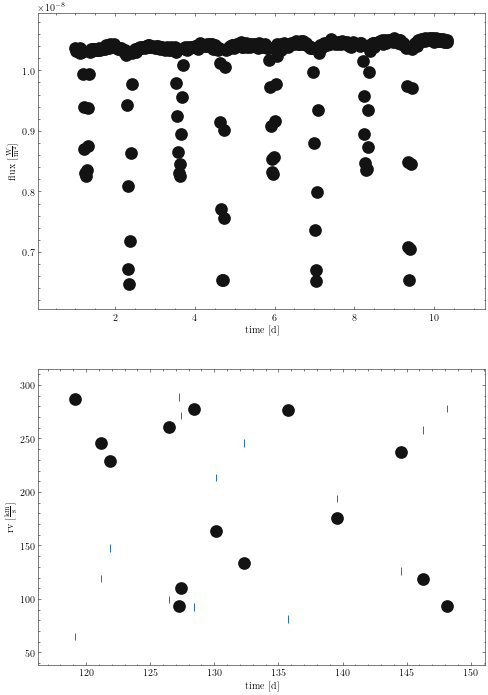

(<autofig.figure.Figure | 2 axes | 3 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [4]:
lc = np.loadtxt('data/lc.V.data')
rv1 = np.loadtxt('data/rv1.data')
rv2 = np.loadtxt('data/rv2.data')

b = phoebe.default_binary()
b.add_dataset('lc', times = lc[:,0], fluxes=lc[:,1], sigmas=lc[:,2], passband='Johnson:V')

b.add_dataset('rv', passband='Johnson:V')
b['times@rv@primary'], b['rvs@rv@primary'], b['sigmas@rv@primary'] = rv1[:,0], rv1[:,1], rv1[:,2]
b['times@rv@secondary'], b['rvs@rv@secondary'], b['sigmas@rv@secondary'] = rv2[:,0], rv2[:,1], rv2[:,2]
b.plot(x='times', show=True)

We will set the pblum mode to dataset-scaled for estimators and optimizers, to avoid having to add pblum to the fitted parameters or adjusting it manually. We will also set distortion_method to 'sphere' to speed up the computation of the light curve.

In [5]:
b.set_value('pblum_mode', 'dataset-scaled')
b.set_value_all('distortion_method', 'sphere')

Set up and flip some constraints needed for adopting the solutions from the estimators:

In [6]:
b.add_constraint('requivsumfrac')
b.add_constraint('requivratio')
b.add_constraint('teffratio')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('teffratio', solve_for='teff@secondary')
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

<ConstraintParameter: {per0@binary@component} = arctan2({esinw@binary@component}, {ecosw@binary@component}) (solar units) => 0.0 deg>

# Periodograms

In [7]:
b.add_solver('estimator.lc_periodogram', solver='lcperiod_bls', 
             algorithm='bls', minimum_n_cycles=2, sample_mode='manual',
             sample_periods = np.linspace(2.,2.5,1000),
             overwrite=True)
b.run_solver('lcperiod_bls', solution='lcperiod_bls_sol', overwrite=True)
print(b['lcperiod_bls_sol'])

ParameterSet: 10 parameters
R  period@lcperiod_bls_sol@sol...: [2.        2.0005005 2.001001  ...
 2.498999  2.4994995 2.5      ] d
R  power@lcperiod_bls_sol@solu...: [716190.645124   716190.645124
 716190.645124   ... 312672.7102061
 327607.88881395 327607.88881395]
   period_factor@lcperiod_bls_...: 1.0
R  fitted_twigs@lcperiod_bls_s...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_bls_...: [2.3433433433433435]
R  fitted_units@lcperiod_bls_s...: ['d']
   adopt_parameters@lcperiod_b...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_bls_s...: True
   comments@lcperiod_bls_sol@s...: 


In [8]:
b.add_solver('estimator.lc_periodogram', solver='lcperiod_ls', 
             algorithm='ls',sample_mode='manual',
             sample_periods = np.linspace(2.,2.5,1000),
             overwrite=True)
b.run_solver('lcperiod_ls', solution='lcperiod_ls_sol', overwrite=True)
print(b['lcperiod_ls_sol'])

ParameterSet: 10 parameters
R  period@lcperiod_ls@lcperiod...: [2.5       2.4994995
 2.498999  ... 2.001001
 2.0005005 2.       ] d
R  power@lcperiod_ls@lcperiod_...: [0.00748456 0.00749116
 0.00749774 ... 0.00358882
 0.00357107 0.00355332]
   period_factor@lcperiod_ls@l...: 1.0
R  fitted_twigs@lcperiod_ls@lc...: ['period@binary@orbit@component']
R  fitted_values@lcperiod_ls@l...: [2.381881881881882]
R  fitted_units@lcperiod_ls@lc...: ['d']
   adopt_parameters@lcperiod_l...: ['period@binary@orbit@component']
   adopt_distributions@lcperio...: False
   adopt_values@lcperiod_ls@lc...: True
   comments@lcperiod_ls@lcperi...: 


In [9]:
b.add_solver('estimator.rv_periodogram', solver='rvperiod', overwrite=True)
b.run_solver('rvperiod', solution='rvperiod_sol', 
             sample_mode='manual', sample_periods=np.linspace(2.,2.5,1000), 
             overwrite=True)
print(b['rvperiod_sol'])

ParameterSet: 10 parameters
R  period@rvperiod@rvperiod_so...: [2.5       2.4994995 2.498999  ...
 2.001001  2.0005005 2.       ] d
R  power@rvperiod@rvperiod_sol...: [0.04686103 0.04659419 0.04632735
 ... 0.00844331 0.00819645
 0.00795217]
   period_factor@rvperiod@rvpe...: 1.0
R  fitted_twigs@rvperiod@rvper...: ['period@binary@orbit@component']
R  fitted_values@rvperiod@rvpe...: [2.340840840840841]
R  fitted_units@rvperiod@rvper...: ['d']
   adopt_parameters@rvperiod@r...: ['period@binary@orbit@component']
   adopt_distributions@rvperio...: False
   adopt_values@rvperiod@rvper...: True
   comments@rvperiod@rvperiod_...: 


In [10]:
np.mean([2.3433433433433435, 2.381881881881882, 2.340840840840841])

2.3553553553553552

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


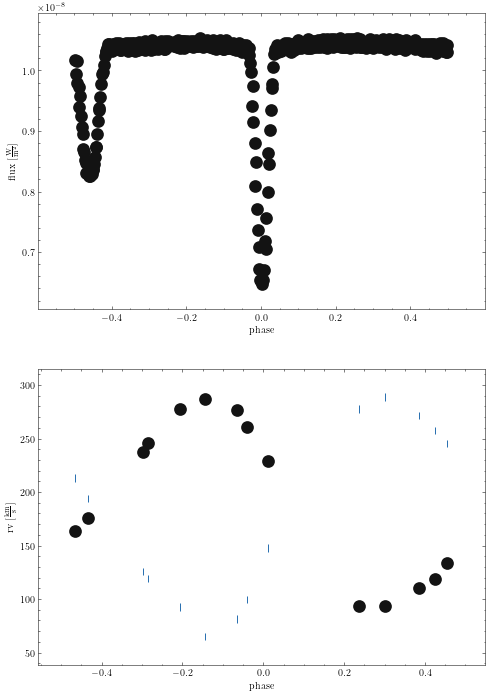

In [11]:
b.adopt_solution('lcperiod_bls_sol')
# b['period@binary'] = 2.346
b.plot(x='phase', show=True)
lc_bls_periodogram_results = get_current_values(b, ['period@binary',])

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


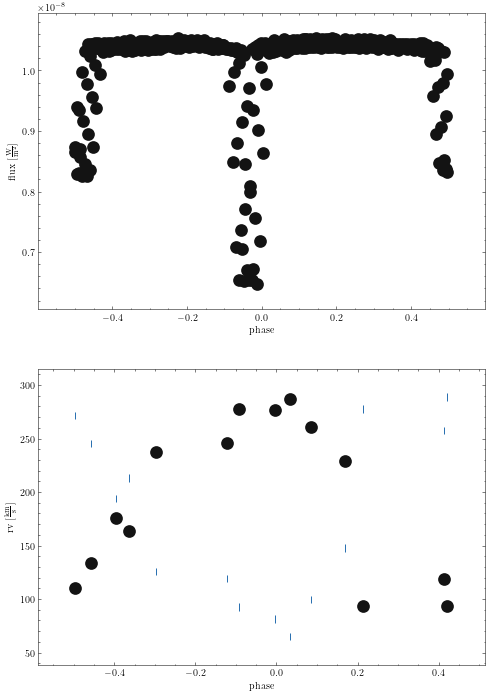

In [12]:
b.adopt_solution('lcperiod_ls_sol')
# b['period@binary'] = 2.346
b.plot(x='phase', show=True)
lc_ls_periodogram_results = get_current_values(b, ['period@binary',])

/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


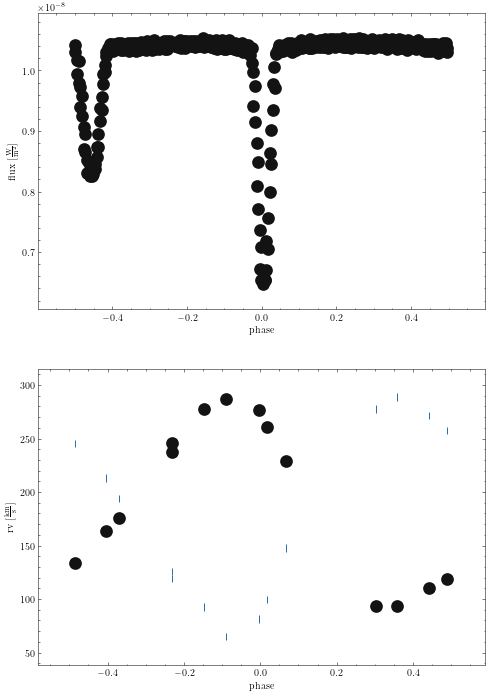

In [13]:
b.adopt_solution('rvperiod_sol')
# b['period@binary'] = 2.346
b.plot(x='phase', show=True)
rv_periodogram_results = get_current_values(b, ['period@binary',])

The lc_periodogram with algorithm='bls' seems to find the best period, so we'll keep that one moving forward:

In [14]:
b.adopt_solution('lcperiod_bls_sol')

<ParameterSet: 16 parameters | contexts: dataset, component>

# V light curve - lc estimators

### EBAI

In [15]:
b.add_solver('estimator.ebai', solver='lc_est_ebai_mlp', ebai_method='mlp', phase_bin = False, overwrite=True)
b.run_solver('lc_est_ebai_mlp', solution='lc_soln_ebai_mlp', overwrite=True)

<ParameterSet: 13 parameters | qualifiers: fitted_units, fitted_values, orbit, adopt_values, input_sigmas, ebai_fluxes, adopt_parameters, adopt_distributions, fitted_twigs, ebai_phases, input_phases, input_fluxes, comments>

100%|████████████████████████████████████████| 472/472 [00:10<00:00, 45.80it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


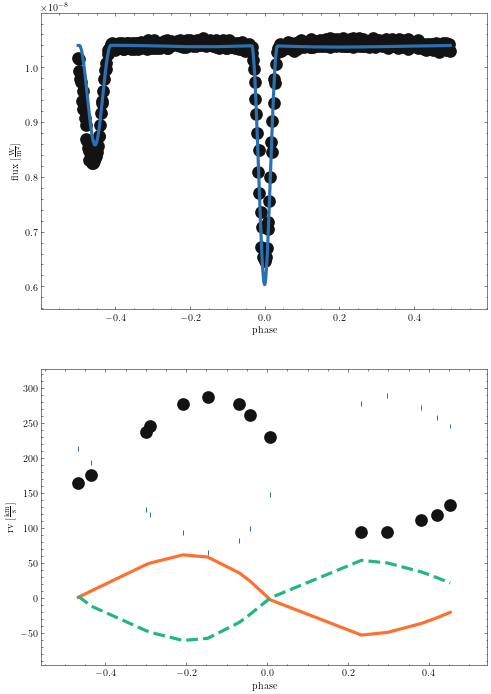

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [16]:
b.adopt_solution('lc_soln_ebai_mlp')
b.run_compute(model='ebai_mlp_model')
b.plot(x='phase',show=True)

In [17]:
ebai_mlp_results = get_current_values(b, ['incl@binary', 'teffratio','requivsumfrac','esinw','ecosw'])

In [18]:
b.add_solver('estimator.ebai', solver='lc_est_ebai_knn', ebai_method='knn', phase_bin = False, overwrite=True)
b.run_solver('lc_est_ebai_knn', solution='lc_soln_ebai_knn', overwrite=True)

<ParameterSet: 13 parameters | qualifiers: fitted_units, fitted_values, orbit, adopt_values, input_sigmas, ebai_fluxes, adopt_parameters, adopt_distributions, fitted_twigs, ebai_phases, input_phases, input_fluxes, comments>

100%|████████████████████████████████████████| 472/472 [00:10<00:00, 46.55it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


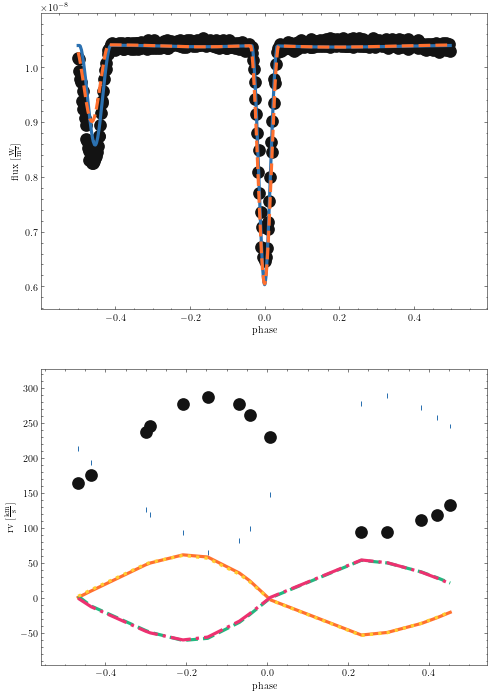

(<autofig.figure.Figure | 2 axes | 9 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [19]:
b.adopt_solution('lc_soln_ebai_knn')
b.run_compute(model='ebai_knn_model', overwrite=True)
b.plot(x='phase',show=True)

In [20]:
ebai_knn_results = get_current_values(b, ['incl@binary', 'teffratio','requivsumfrac','esinw','ecosw'])

In [21]:
b.add_solver('estimator.lc_geometry', solver='lc_est_lcgeom', phase_bin = False)
b.run_solver('lc_est_lcgeom', solution='lc_soln_lcgeom')

<ParameterSet: 21 parameters | qualifiers: secondary_depth, adopt_values, fitted_twigs, comments, analytic_phases, orbit, input_sigmas, input_fluxes, primary_phase, fitted_values, analytic_best_model, primary_width, adopt_distributions, secondary_width, eclipse_edges, fitted_units, primary_depth, adopt_parameters, input_phases, analytic_fluxes, secondary_phase>

In [22]:
b.flip_constraint('ecc', solve_for='esinw')
b.flip_constraint('per0', solve_for='ecosw')

<ConstraintParameter: {ecosw@binary@component} = {ecc@binary@component} * (cos({per0@binary@component})) (solar units) => 0.058111623370685345>

100%|████████████████████████████████████████| 472/472 [00:10<00:00, 46.27it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


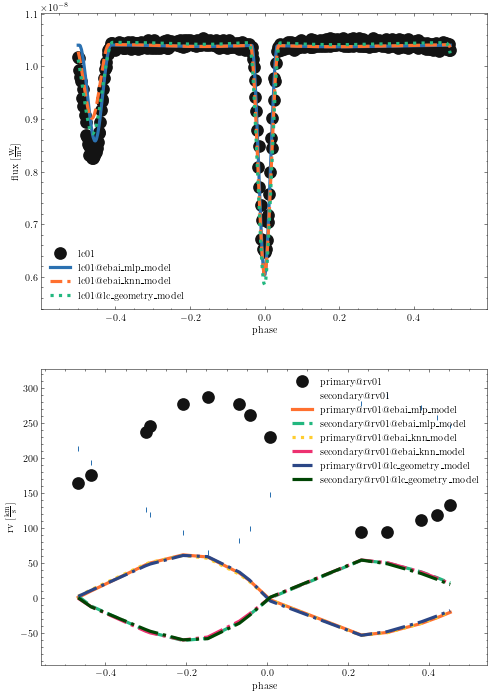

(<autofig.figure.Figure | 2 axes | 12 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [23]:
b.adopt_solution('lc_soln_lcgeom')
b.run_compute(model='lc_geometry_model')
b.plot(x='phase', legend=True, save='testcase_estimators.png', show=True)

In [24]:
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')
lc_geometry_results = get_current_values(b, ['incl@binary', 'teffratio','requivsumfrac','esinw','ecosw'])

# RV - rv_geometry

In [25]:
b.add_solver('estimator.rv_geometry', solver='rvgeom')
b.run_solver('rvgeom', solution='rvgeom_sol')

<ParameterSet: 17 parameters | components: primary, secondary>

In [26]:
b['adopt_parameters@rvgeom_sol'] = ['q', 'asini@binary', 'vgamma']

In [27]:
b.flip_constraint('asini@binary', solve_for='sma@binary')

<ConstraintParameter: {sma@binary@component} = {asini@binary@component} / (sin({incl@binary@component})) (solar units) => 5.3 solRad>

100%|████████████████████████████████████████| 472/472 [00:10<00:00, 45.98it/s]
/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


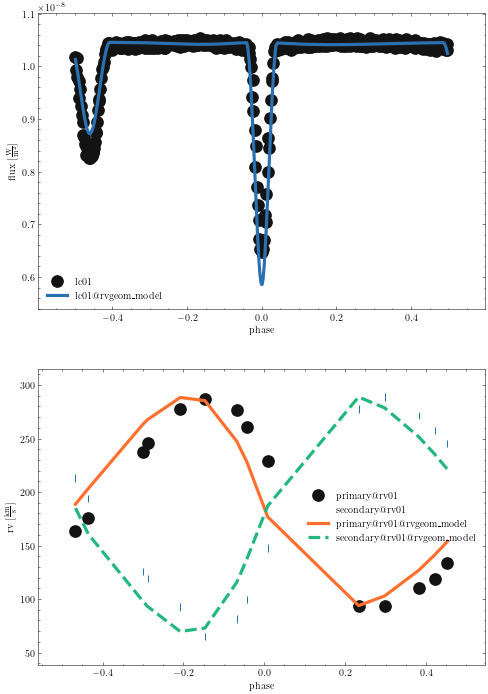

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [29]:
# b.flip_constraint('ecc', solve_for='esinw')
# b.flip_constraint('per0', solve_for='ecosw')
b.adopt_solution('rvgeom_sol')
# b['period@binary'] = 2.345678901
b.run_compute(model='rvgeom_model')
b.plot(x='phase', model='rvgeom_model', legend=True, show=True)

In [30]:
rv_geometry_results = get_current_values(b, ['q', 'asini@binary','vgamma'])

In [31]:
b.save('bundles/after_estimators.bundle')

'bundles/after_estimators.bundle'

# Plot results

## data

In [32]:
times = b.get_value('times', context='dataset', dataset='lc01')
phases = b.to_phase(times)
fluxes_true = b.get_value('fluxes', context='dataset', dataset='lc01')
sigmas_true = b.get_value('sigmas', context='dataset', dataset='lc01')

times_rv = b.get_value('times', context='dataset', component='primary', dataset='rv01')
phases_rv = b.to_phase(times_rv)
rvs1 = b.get_value('rvs', context='dataset', component='primary', dataset='rv01')
rvs2 = b.get_value('rvs', context='dataset', component='secondary', dataset='rv01')
sigmas1 = b.get_value('sigmas', context='dataset', component='primary', dataset='rv01')
sigmas2 = b.get_value('sigmas', context='dataset', component='secondary', dataset='rv01')

In [33]:
lc_ebai_mlp = get_model(b, model='ebai_mlp_model', dataset='lc01', phase_order=True)
lc_ebai_knn = get_model(b, model='ebai_knn_model', dataset='lc01', phase_order=True)
lc_geom = get_model(b, model='lc_geometry_model', dataset='lc01', phase_order=True)
rv_geom1, rv_geom2 = get_model(b, model='rvgeom_model', dataset='rv01', model_type='rv', phase_order=True)

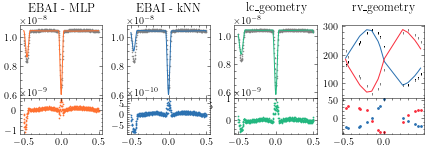

In [49]:
fig, ((ax1, ax1b, ax2, ax3), (ax4, ax4b, ax5, ax6)) = plt.subplots(nrows = 2, ncols = 4, figsize=(7.25,2), 
                                                       gridspec_kw={'height_ratios': [2, 1]})

fig.subplots_adjust(hspace=0, wspace=0.3)
lc_datapoints = {'fmt': '.', 'ms': 1, 'c': '0.5', 'zorder':0,}
rv1_datapoints = {'fmt': ',', 'c': '0.0', 'zorder':0}
rv2_datapoints = {'fmt': ',', 'c': '0.5',  'zorder':0}
model_kwargs = {'lw': 1, 'zorder': 1}
res_kwargs = {'s': 0.5}
res_rv_kwargs = {'s': 3}
for ax in [ax1, ax1b, ax2]:
    ax.errorbar(x=phases, y=fluxes_true, yerr=sigmas_true, rasterized=True, **lc_datapoints)
ax3.errorbar(x=phases_rv, y=rvs1, yerr=sigmas1, rasterized=True, **rv1_datapoints)
ax3.errorbar(x=phases_rv, y=rvs2, yerr=sigmas2, rasterized=True, **rv2_datapoints)

ax1.plot(lc_ebai_mlp[:,1], lc_ebai_mlp[:,2], c=phoebe_c['orange'], **model_kwargs)
ax4.scatter(lc_ebai_mlp[:,1], lc_ebai_mlp[:,3], c=phoebe_c['orange'], **res_kwargs)
ax1b.plot(lc_ebai_knn[:,1], lc_ebai_knn[:,2], c=phoebe_c['blue'], **model_kwargs)
ax4b.scatter(lc_ebai_knn[:,1], lc_ebai_knn[:,3], c=phoebe_c['blue'], **res_kwargs)
ax2.plot(lc_geom[:,1], lc_geom[:,2],c=phoebe_c['green'], **model_kwargs)
ax5.scatter(lc_geom[:,1], lc_geom[:,3], c=phoebe_c['green'], **res_kwargs)

ax3.plot(rv_geom1[:,1], rv_geom1[:,2], c=phoebe_c['blue'], label='primary', **model_kwargs)
ax3.plot(rv_geom2[:,1], rv_geom2[:,2], c=phoebe_c['red'], label='secondary', **model_kwargs)
ax6.scatter(rv_geom1[:,1], rv_geom1[:,3], c=phoebe_c['blue'], **res_rv_kwargs)
ax6.scatter(rv_geom2[:,1], rv_geom2[:,3], c=phoebe_c['red'],**res_rv_kwargs)

# ax3.legend()

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([])
# for ax in [ax4, ax5, ax6]:
#     ax.set_xlabel('Phase')
# ax1.set_ylabel('Flux [W/m$^2$]')
# ax2.set_ylabel('Flux [W/m$^2$]', labelpad=12)
# ax3.set_ylabel('RV [km/s]')
# ax4.set_ylabel('Residuals [W/m$^2$]')
# ax5.set_ylabel('Residuals [W/m$^2$]')
# ax6.set_ylabel('Residuals [km/s]')

ax1.set_title('EBAI - MLP', pad=14)
ax1b.set_title('EBAI - kNN', pad=14)
ax2.set_title('lc\_geometry', pad=14)
ax3.set_title('rv\_geometry', pad=14)

# fig.tight_layout()
fig.savefig('figs/2_estimators_data.pdf', dpi=300)

## parameter values

In [50]:
truths, twigs, labels = get_truths_labels()
true_vals = {}
for twig, value in zip(twigs, truths):
    true_vals[twig] = value  

model, twig, current_solution, previous_lc, previous_rv


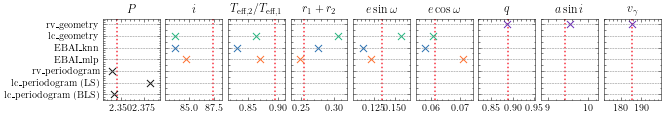

In [51]:
twigs = [
    'period@binary',
    'incl@binary',
     'teffratio',
     'requivsumfrac',
     'esinw',
     'ecosw',
     'q',
     'asini@binary',
     'vgamma',
]

labels = [r'$P$', 
          r'$i$', 
          r'$T_{\mathrm{eff},2}/T_{\mathrm{eff},1}$', 
          r'$r_1+r_2$', 
          r'$e\sin\omega$', 
          r'$e\cos\omega$',
          r'$q$',
          r'$a\sin i$',
          r'$v_{\gamma}$'
         ]

fig, axes = plt.subplots(nrows = 1, ncols = len(labels), figsize=(10,1.5))
fig.subplots_adjust(hspace=0, wspace=0.1)

models = [lc_bls_periodogram_results, lc_ls_periodogram_results, rv_periodogram_results, ebai_mlp_results, ebai_knn_results, lc_geometry_results, rv_geometry_results]
model_labels = [r'lc_periodogram (BLS)', r'lc_periodogram (LS)', r'rv_periodogram', r'EBAI_mlp', r'EBAI_knn', r'lc_geometry', r'rv_geometry']
colors = [phoebe_c['black'], phoebe_c['black'], phoebe_c['black'], phoebe_c['orange'], phoebe_c['blue'], phoebe_c['green'], phoebe_c['purple']]
# import cmasher as cmr
# colors = cmr.take_cmap_colors('cmr.rainforest', len(models), cmap_range=(0.05, 0.85), return_fmt='hex')
print('model, twig, current_solution, previous_lc, previous_rv')
for ax, label, twig in zip(axes, labels, twigs):
    ax.set_title(label)
    # ax.set_ylabel(ylabel)
    # ax.set_yticks([])
    ax.margins(0.25)
    for i, model in enumerate(models):
        ax.axhline(i, linestyle='--', lw=0.5, color='gray')
        if twig in model.keys():
            # print(model_labels[i], twig, model[twig], b_prev_lc.get_value(twig), b_prev_rv.get_value(twig))
            ax.scatter(model[twig], i, c=colors[i], s=50, marker='x', zorder=1)
            # ax.scatter(b_prev_lc.get_value(twig), i, marker='o', fc='gray', ec='none')
            # ax.scatter(b_prev_rv.get_value(twig), i, marker='o', fc='none', ec='gray')
        else:
            pass
    ax.axvline(x=true_vals[twig], ls=':', lw=1.5, c=phoebe_c['red'], zorder=0)
    ax.set_ylim(-0.5, len(models)-1+0.5)
        
for i,ax in enumerate(axes):
    # ax.grid(visible=True, which='major', axis='y', linestyle='--')
    if i==0:
        ax.set_yticks(np.arange(0,len(model_labels),1),model_labels)
    else:
        ax.yaxis.set_ticklabels([])
# fig.tight_layout()
fig.savefig('figs/3_estimators_vals.pdf', dpi=300)